In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.ndimage.filters import convolve1d
import draw_hmm as hmm
import kalman_helper as kalman
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

Referencias:
- https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation
- https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

Toy example:
- Robot en cuarto circular
- Quiere determinar su posicion
- Inicialemente puede estar en cualquiera de las N posibles posiciones diferentes
- Avanza de manera deterministica 1 posicion en cada paso
- La medicion de su posicion tiene error.

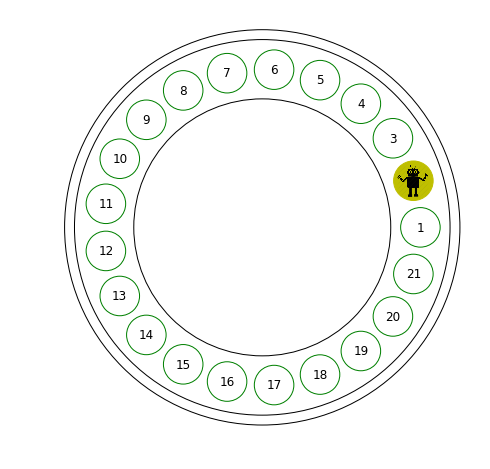

In [3]:
kalman.plot_robot_room(N = 21, loc = 2)

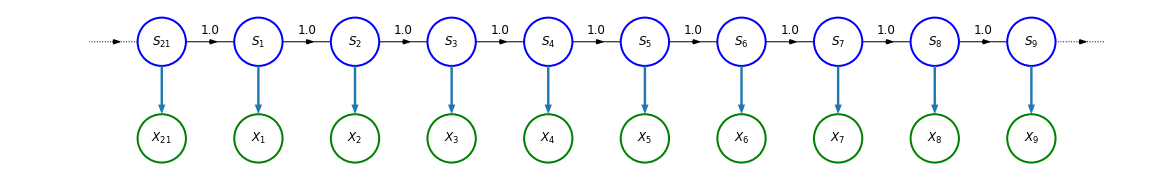

In [4]:
hmm.plot_basic_hmm_model(N = 21, N_states_visible = 10, circular = True, stay_step_prob = 0, one_step_prob = 1.0, two_step_prob = 0)

### Modelo
$S_k = S_{k-1} + 1$

$X_k = S_k + N$

- La $P(X|S_k)$ es el likelihood (Distribucion de observación, es lo que mido dado que estoy en un estado en particular)
- La $P(S_k)$ es la probabilidad apriori (distribucion antes de medir) - prior, belief
- La $P(S_k|X)$ es la probabilidad a posteriori (distribucion de S despues de realizar la medicion)

$P(S_k|X) = \frac{P(X|S_k)P(S_K)}{P(X)}$

$P(X) = \sum_i{P(X,S_i)} = \sum_i{P(X|S_i)P(S_i)}$



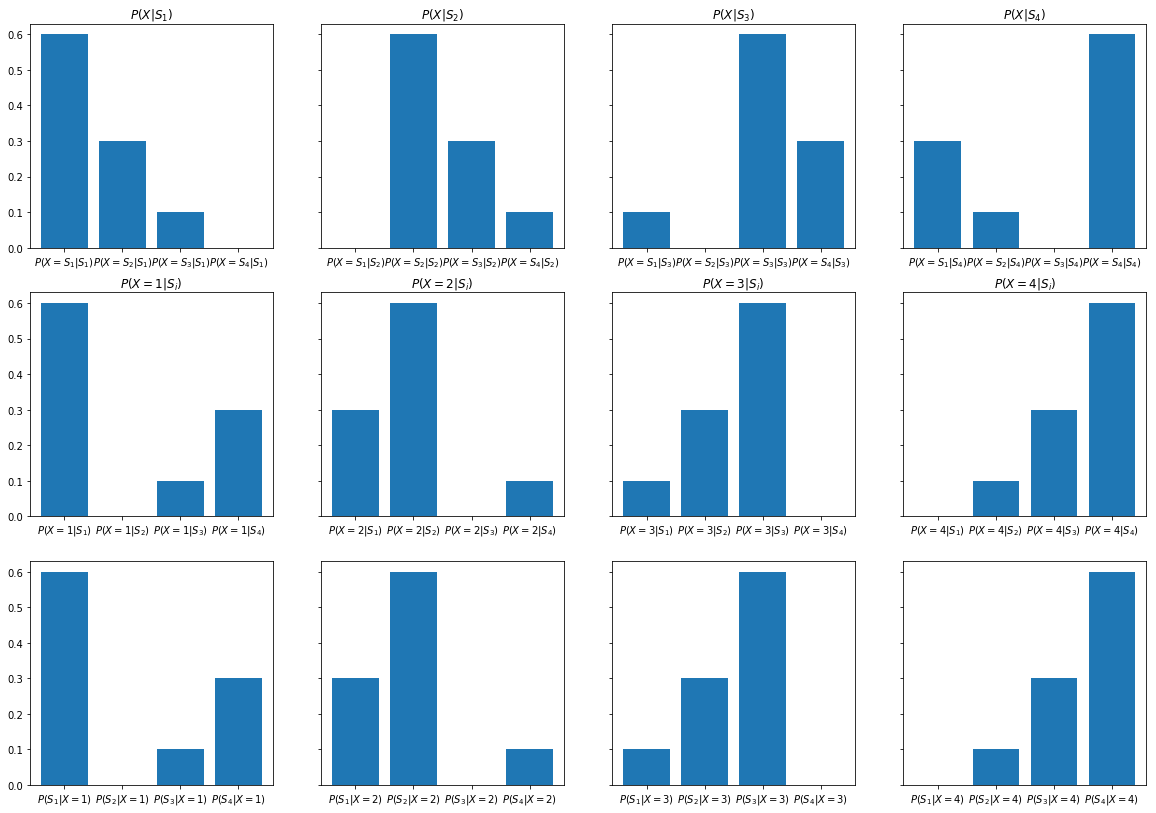

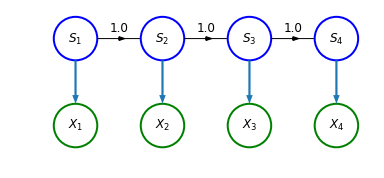

In [5]:
N = 4
idxs = np.linspace(1,N,N)
#P_sk = np.zeros(N); P_sk[0] = 0.5; P_sk[1] = 0.3; P_sk[2] = 0.15; P_sk[3] = 0.05; 
P_sk = np.zeros(N); P_sk[0] = 0.25; P_sk[1] = 0.25; P_sk[2] = 0.25; P_sk[3] = 0.25; 
P_xk_s1 = np.zeros(N); P_xk_s1[0] = 0.6; P_xk_s1[1] = 0.3; P_xk_s1[2] = 0.1; P_xk_s1[3] = 0.0
P_xk_s2 = np.zeros(N); P_xk_s2[1] = 0.6; P_xk_s2[2] = 0.3; P_xk_s2[3] = 0.1; P_xk_s2[0] = 0.0
P_xk_s3 = np.zeros(N); P_xk_s3[2] = 0.6; P_xk_s3[3] = 0.3; P_xk_s3[0] = 0.1; P_xk_s3[1] = 0.0
P_xk_s4 = np.zeros(N); P_xk_s4[3] = 0.6; P_xk_s4[0] = 0.3; P_xk_s4[1] = 0.1; P_xk_s4[2] = 0.0

f, ax = plt.subplots(3, 4, sharey=True, sharex=False, figsize = (20,14))
ax = ax.flatten()

plt.sca(ax[0])
plt.xticks(idxs, ['$P(X=S_1|S_1)$','$P(X=S_2|S_1)$','$P(X=S_3|S_1)$','$P(X=S_4|S_1)$']) 
ax[0].bar(idxs,P_xk_s1)
ax[0].set_title('$P(X|S_1)$')

plt.sca(ax[1])
plt.xticks(idxs, ['$P(X=S_1|S_2)$','$P(X=S_2|S_2)$','$P(X=S_3|S_2)$','$P(X=S_4|S_2)$']) 
ax[1].bar(idxs,P_xk_s2)
ax[1].set_title('$P(X|S_2)$')


plt.sca(ax[2])
plt.xticks(idxs, ['$P(X=S_1|S_3)$','$P(X=S_2|S_3)$','$P(X=S_3|S_3)$','$P(X=S_4|S_3)$']) 
ax[2].bar(idxs,P_xk_s3)
ax[2].set_title('$P(X|S_3)$')

plt.sca(ax[3])
plt.xticks(idxs, ['$P(X=S_1|S_4)$','$P(X=S_2|S_4)$','$P(X=S_3|S_4)$','$P(X=S_4|S_4)$']) 
ax[3].bar(idxs,P_xk_s4)
ax[3].set_title('$P(X|S_4)$')

for x in range(4):
    plt.sca(ax[x+4])
    likelihood = [P_xk_s1[x], P_xk_s2[x], P_xk_s3[x],P_xk_s4[x]]
    plt.xticks(idxs, ['$P(X=%s|S_1)$'%(x+1),'$P(X=%s|S_2)$'%(x+1),'$P(X=%s|S_3)$'%(x+1),'$P(X=%s|S_4)$'%(x+1)]) 
    ax[x+4].bar(idxs,likelihood)
    ax[x+4].set_title('$P(X=%s|S_i)$'%(x+1))
    P_sk_xk_unorm = P_sk*likelihood
    P_sk_xk_unorm = P_sk_xk_unorm/P_sk_xk_unorm.sum()
    plt.sca(ax[x+8])
    plt.xticks(idxs, ['$P(S_1|X=%s)$'%(x+1),'$P(S_2|X=%s)$'%(x+1),'$P(S_3|X=%s)$'%(x+1),'$P(S_4|X=%s)$'%(x+1)]) 
    ax[x+8].bar(idxs,P_sk_xk_unorm)
    
    
#plt.sca(ax[8])
#plt.xticks(idxs, ['$P(S_1)$','$P(S_2)$','$P(S_3)$','$P(S_4)$'])
#ax[8].bar(idxs,P_sk) 
    

plt.show()
hmm.plot_basic_hmm_model(N = 4, N_states_visible = 4, figsize=(6,3),circular = False, stay_step_prob = 0, 
                         one_step_prob = 1.0, two_step_prob = 0)

Es interesante notar que: 
- $P(S_1|X=4) = 0$
- Significa que jamas podria observar un 4 estando en el estado $S_1$ 
- Si observamos $P(X=4|S_1) = 0$

Lo mismo:
- $P(S_4|X=3) = 0 = P(X=3|S_4) = 0$
- $P(S_3|X=2) = 0 = P(X=2|S_3) = 0$
- $P(S_2|X=1) = 0 = P(X=1|S_2) = 0$

$P(S_i|X=j) \ne P(X=i|S_j)$

In [6]:
N = 21
scale = 4 #Error de observacion
indexes = np.linspace(1,N,N)
get_observation_distribution = kalman.get_exponential_distribution
get_observation_distribution = kalman.get_exponential_distribution_symetric
observed_dist_1 = get_observation_distribution(indexes, loc = 1, scale = scale)
# get_exponential_distribution
kalman.plot_distribution(indexes, observed_dist_1, \
                         title = 'Distribucion de la observacion dado que el robot observa en la posicion 1')

TypeError: plot_distribution() got multiple values for argument 'title'

In [ ]:
# Prediccion inicial
predicted_dist_1 = np.ones(N)/N
kalman.plot_distribution(indexes, predicted_dist_1, title = 'Distribucion inicial (Uniforme): (Incertudumbre total)')
loc = 1 #Ubicacion inicial


observed_dist_1 = get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_1, title = 'Observacion: Distribucion de la observación en la posicion 1')

updated_dist_1 = kalman.after_observation_distribution_update(predicted_dist_1, observed_dist_1)
kalman.plot_distribution(indexes, updated_dist_1,title = 'Update: Producto de observada con la distribucion apriori (Inicial)')

predicted_dist_2 = kalman.deterministic_next_step_distribution_prediction(updated_dist_1)
kalman.plot_distribution(indexes, predicted_dist_2, title = 'Prediccion (Traslacion del update en una posicion)')
loc = loc + 1
observed_dist_2 = get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_2, title = 'Observacion: Distribucion de la observación en la posicion 2')
updated_dist_2 = kalman.after_observation_distribution_update(predicted_dist_2, observed_dist_2)
kalman.plot_distribution(indexes, updated_dist_2, title = 'Update: Producto de observada en pos 2 con la distribucion apriori (Predicion)')

predicted_dist_3 = kalman.deterministic_next_step_distribution_prediction(updated_dist_2)
kalman.plot_distribution(indexes, predicted_dist_3, title = 'Prediccion (Sabiendo que el robot avanza una posicion)')
loc = loc + 1
observed_dist_3 = get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_3, title = 'Observacion: Distribucion de la observación en la posicion 3')
updated_dist_3 = kalman.after_observation_distribution_update(predicted_dist_3, observed_dist_3)
kalman.plot_distribution(indexes, updated_dist_3, title = 'Update: Obsevada en posicion 3 con prediccion de posicion 3')

updated_dist_n_1 = updated_dist_3
for i in range(1*N):
    predicted_dist_n = kalman.deterministic_next_step_distribution_prediction(updated_dist_n_1)
    loc = loc + 1
    observed_dist_n = get_observation_distribution(indexes, loc = loc, scale = scale)
    updated_dist_n_1 = kalman.after_observation_distribution_update(predicted_dist_n, observed_dist_n)
    
kalman.plot_distribution(indexes, updated_dist_n_1, title = 'Update: Luego de 1 vu mas')


Que pasa ahora si el movimiento del robot no es deterministico?
- Cada vez que el rebot se mueve tiene una distribucion de moverse a las distintas posiciones

In [ ]:
stay_step_prob = 0.15
one_step_prob = 0.50
two_step_prob = 0.35
hmm.plot_basic_hmm_model(N = 21, N_states_visible = 10, circular = True, stay_step_prob=stay_step_prob, 
                         one_step_prob= one_step_prob, two_step_prob= two_step_prob)

### Modelo
$S_k = S_{k-1} + D$

$X_k = S_k + N$

### Update (Bayes: producto de dos pdfs normalizado)

- La $P(X_k|S_k)$ es el likelihood (Distribucion de observación, es lo que mido dado que estoy en un estado en particular)
- La $P(S_k)$ es la probabilidad apriori (distribucion antes de medir)
- La $P(S_k|X_k)$ es la probabilidad a posteriori (distribucion de S despues de realizar la medicion)

$P(S_k|X_k) = \frac{P(X_k|S_k)P(S_K)}{P(X_k)}$

$P(X_k) = \sum_i{P(X_k,S_i)} = \sum_i{P(X_k|S_i)P(S_i)}$

### Prediction (Convolucion: Suma de V.A independientes)
Es la convolucion ya que es suma de dos variable aleatorias:
$S_{k-1} + D$


(<matplotlib.figure.Figure at 0x114237668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114171fd0>)

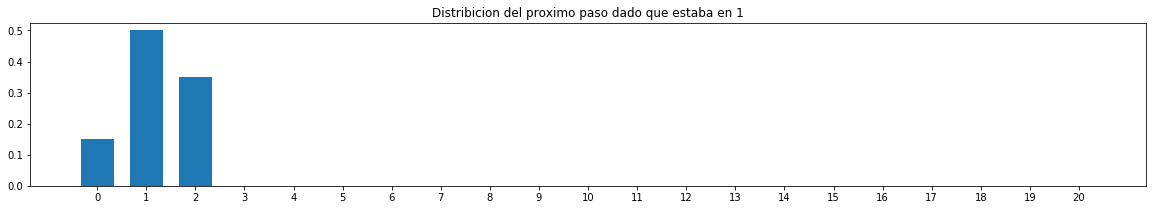

In [10]:
#scale_model = 1
#next_step_distribution = kalman.get_next_step_distribution(indexes, scale = scale_model)
next_step_distribution = np.zeros(N)
next_step_distribution[0] = stay_step_prob
next_step_distribution[1] = one_step_prob
next_step_distribution[2] = two_step_prob
kalman.plot_distribution(indexes-1, next_step_distribution, title = 'Distribicion del proximo paso dado que estaba en 1')

(<matplotlib.figure.Figure at 0x114384160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11430ab70>)

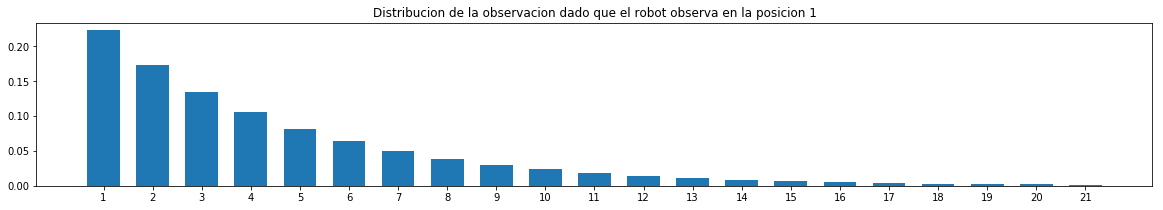

In [11]:
get_observation_distribution = kalman.get_exponential_distribution
#get_observation_distribution = kalman.get_exponential_distribution_symetric
observed_dist_1 = get_observation_distribution(indexes, loc = 1, scale = scale)
# get_exponential_distribution
kalman.plot_distribution(indexes, observed_dist_1, \
                         title = 'Distribucion de la observacion dado que el robot observa en la posicion 1')

(<matplotlib.figure.Figure at 0x113765d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11325c668>)

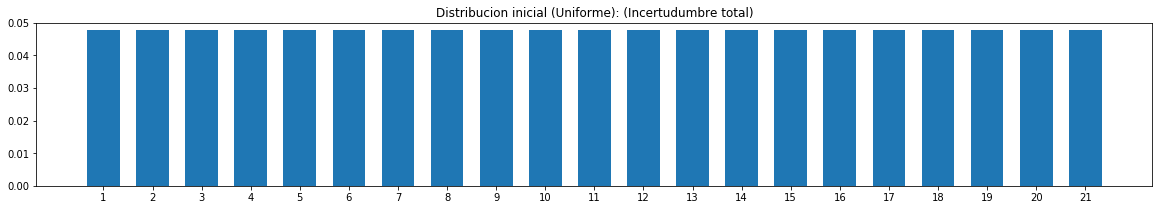

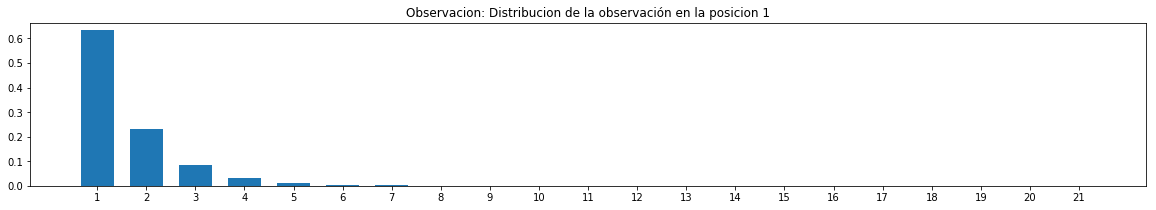

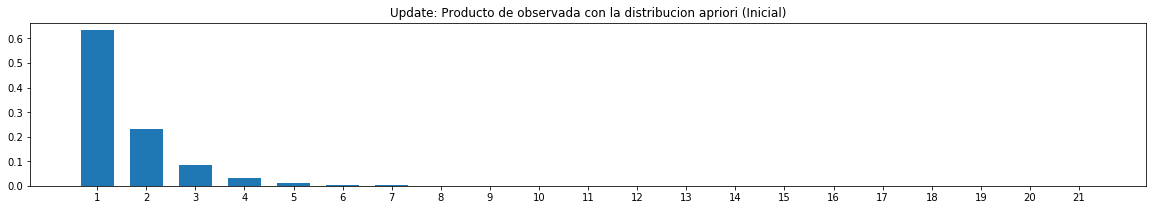

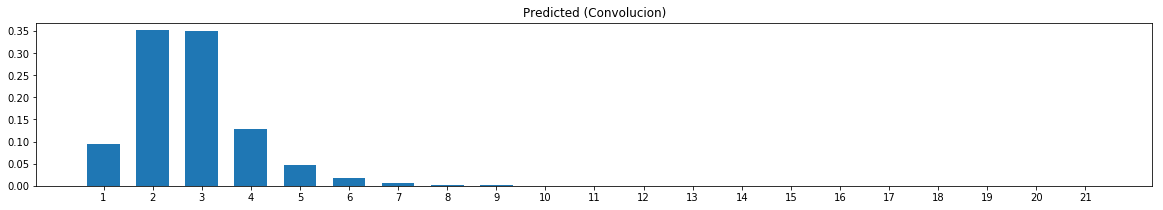

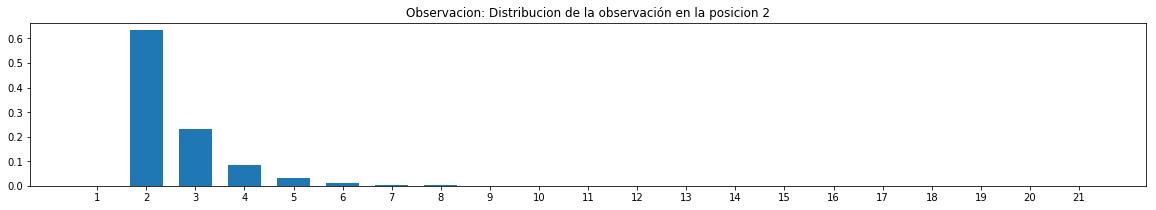

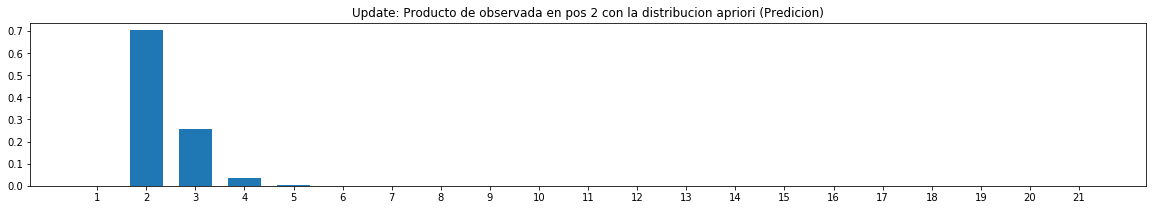

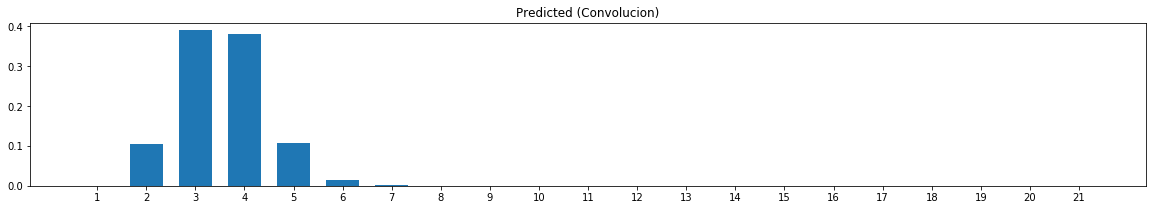

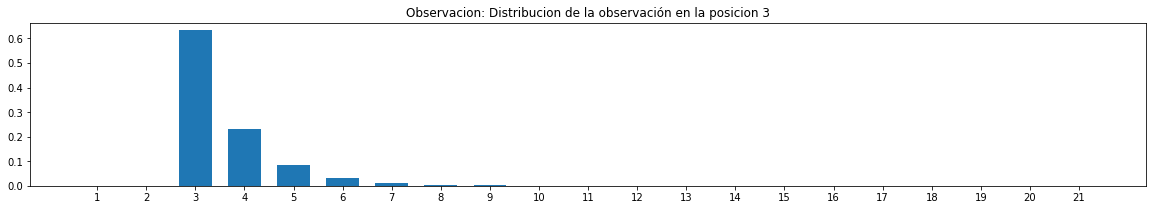

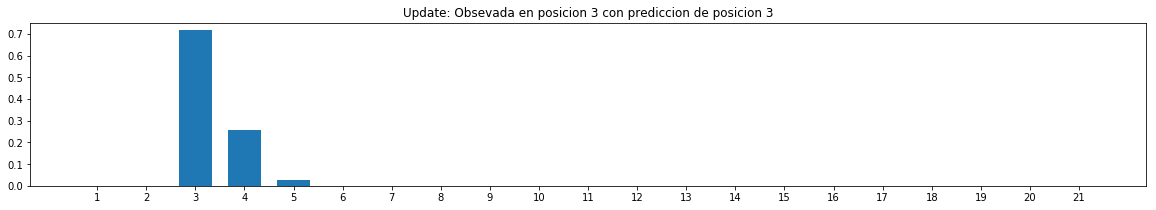

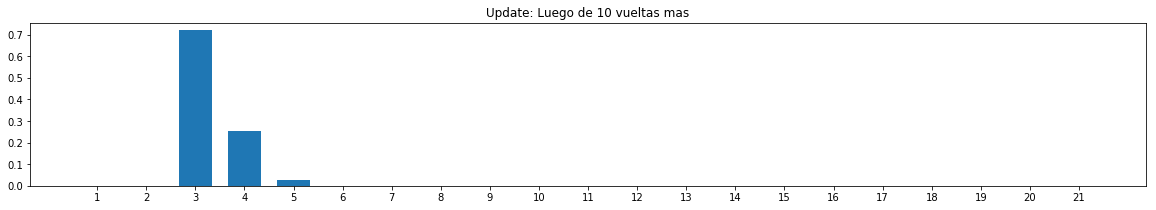

In [12]:
scale = 1 # observation
N = 21
indexes = np.linspace(1,N,N)
# Prediccion inicial
predicted_dist_1 = np.ones(N)/N
kalman.plot_distribution(indexes, predicted_dist_1, title = 'Distribucion inicial (Uniforme): (Incertudumbre total)')
loc = 1 #Ubicacion inicial

observed_dist_1 = get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_1, title = 'Observacion: Distribucion de la observación en la posicion 1')
updated_dist_1 = kalman.after_observation_distribution_update(predicted_dist_1, observed_dist_1)
kalman.plot_distribution(indexes, updated_dist_1,title = 'Update: Producto de observada con la distribucion apriori (Inicial)')

predicted_dist_2 = kalman.stochastic_next_step_distribution_prediction(updated_dist_1, next_step_distribution)
kalman.plot_distribution(indexes, predicted_dist_2,title = 'Predicted (Convolucion)')
loc = loc + 1
observed_dist_2 = get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_2, title = 'Observacion: Distribucion de la observación en la posicion 2')
updated_dist_2 = kalman.after_observation_distribution_update(predicted_dist_2, observed_dist_2)
kalman.plot_distribution(indexes, updated_dist_2, title = 'Update: Producto de observada en pos 2 con la distribucion apriori (Predicion)')

predicted_dist_3 = kalman.stochastic_next_step_distribution_prediction(updated_dist_2, next_step_distribution)
kalman.plot_distribution(indexes, predicted_dist_3, title = 'Predicted (Convolucion)')
loc = loc + 1
observed_dist_3 = get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_3, title = 'Observacion: Distribucion de la observación en la posicion 3')
updated_dist_3 = kalman.after_observation_distribution_update(predicted_dist_3, observed_dist_3)
kalman.plot_distribution(indexes, updated_dist_3, title = 'Update: Obsevada en posicion 3 con prediccion de posicion 3')

updated_dist_n_1 = updated_dist_3
for i in range(N*10):
    predicted_dist_n = kalman.stochastic_next_step_distribution_prediction(updated_dist_n_1, next_step_distribution)
    loc = loc + 1
    observed_dist_n = get_observation_distribution(indexes, loc = loc, scale = scale)
    updated_dist_n_1 = kalman.after_observation_distribution_update(predicted_dist_n, observed_dist_n)
    
kalman.plot_distribution(indexes, updated_dist_n_1, title = 'Update: Luego de 10 vueltas mas')
# agregar a las graficas la varianza y argmax

In [220]:
from IPython import display
def get_next_step_distribution(N = 21, probs=[0.15, 0.5, 0.35]):
    next_step_distribution = np.zeros(N)
    next_step_distribution[:len(probs)] = probs
    return next_step_distribution


def iterate_filter(iterations = 21*10+10,N = 21, loc = 1, scale = 1, mirror = False, 
                   get_observation_distribution = kalman.get_exponential_distribution, 
                   predicted = np.ones(N)/N):
    fig, ax = plt.subplots(3,2, figsize=(20, 6), sharex = True)
    ax = ax.flatten()
    indexes = np.linspace(1,N,N)
    
    next_step_distribution = get_next_step_distribution()
    
    for i in range(iterations):
        prior = predicted
        observed = get_observation_distribution(indexes, loc = loc, scale = scale, mirror = mirror)
        observed_not_mirrored = get_observation_distribution(indexes, loc = loc, scale = scale, mirror = False)
        updated = kalman.after_observation_distribution_update(prior, observed)
        predicted = kalman.stochastic_next_step_distribution_prediction(updated, next_step_distribution)
        kalman.plot_iteration(indexes, next_step_distribution, observed,prior, observed_not_mirrored,updated,predicted, fig=fig)
        display.display(plt.gcf())
        loc = loc + 1
        input("Press ENTER to continue.")
        ax[0].cla();ax[1].cla();ax[2].cla();ax[3].cla();ax[4].cla();ax[5].cla()
        display.clear_output(wait=True)
    kalman.plot_iteration(indexes, next_step_distribution, observed, prior, observed_not_mirrored,updated,predicted, fig=fig)

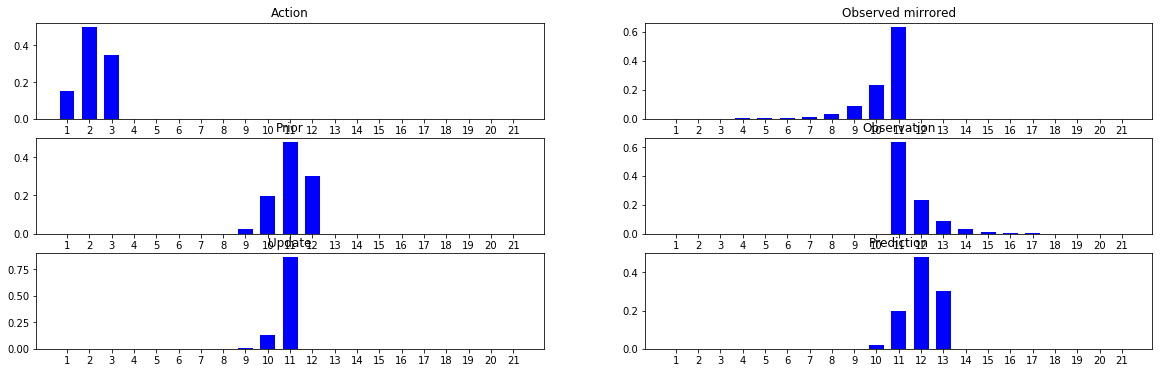

In [185]:
iterate_filter(iterations=11,mirror = True)

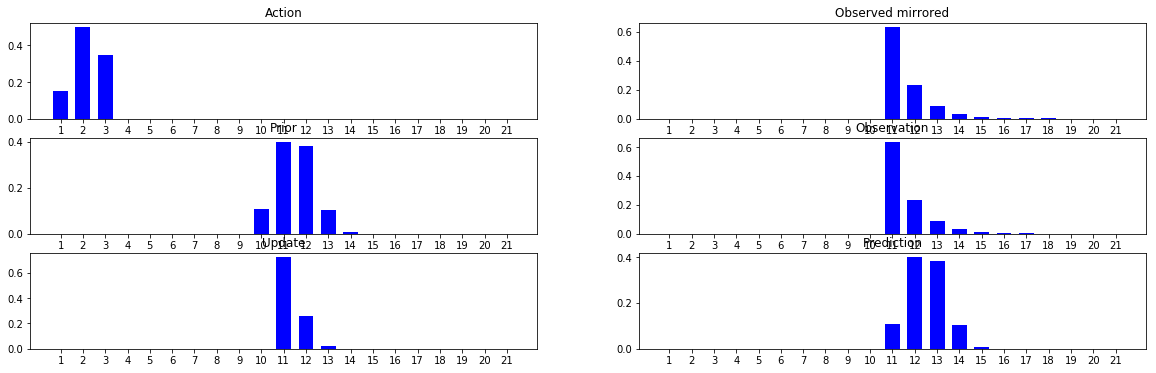

In [186]:
iterate_filter(iterations=11,mirror = False)

In [215]:
def get_multimodal_distribution(indexes, loc = 1, scale = 2, mirror = False):
    positions = np.array([3, 9, 17])
    pulse = np.array([0.2, 0.8, 1, 0.8, 0.2])
    uniform = np.ones(len(indexes))*0.1
    uniform[positions] = 1
    center = int(int(len(indexes))/2)
    uniform = convolve1d(uniform, pulse, mode = 'wrap')
    exponential_dist = uniform/uniform.sum()
    if mirror:
        return np.roll(exponential_dist[::-1],loc)
    return np.roll(exponential_dist,loc-1)

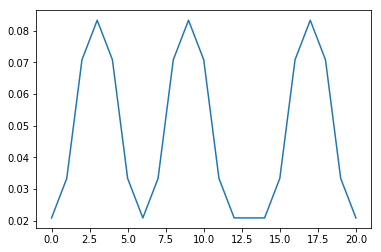

In [216]:
plt.plot(get_multimodal_distribution(indexes, loc = 1, scale = 2, mirror = False))

In [37]:
from ipywidgets import widgets
from IPython.display import display
button = widgets.Button(description="Click Me!")
display(button)

def on_button_clicked(b):
    print("Button clicked.")

button.on_click(on_button_clicked)

module://ipykernel.pylab.backend_inline


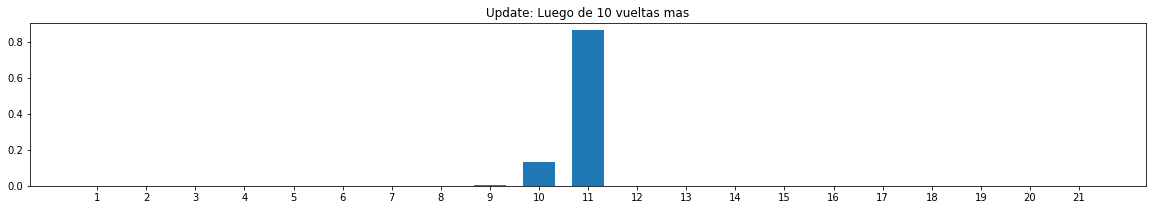

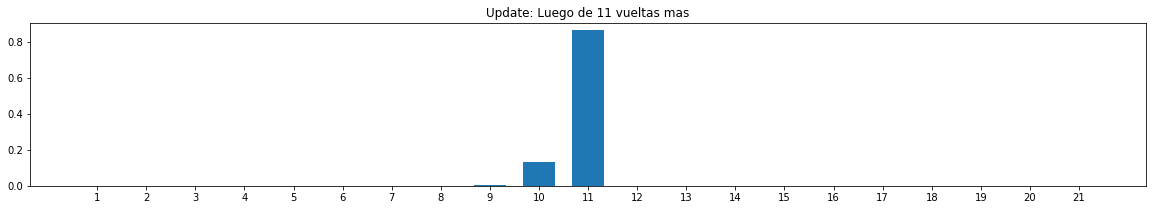

In [15]:
iterate_filter(mirror = True)

# Propiedades de las Gaussians
- ¿Que pasa con las medias y las varianzas cuando sumo (convolucion de pdfs) dos V.A?
- ¿Que pasa cuando multiplico dos pdfs gaussianas?

http://129.173.120.78/~kreplak/wordpress/wp-content/uploads/2010/12/gaussians_convolutions_lecture3.pdf

# Filtro de Kalman
- Si el error de medicion y del modelo son gaussianas
- estados infinitos

# Queremos estimar la posición de un movil en función del tiempo bajo las siguientes condiciones:
- Nuestra medicion tiene ruido
- Muestramos uniformemente
- Cada vez que muestramos, el movil avanzó cierta distancia, pero esa distancia no es una constante sino un V.A gaussiana.

# Observacion
La convolucion entre dos pdfs gaussianas es una gaussiana con media igual a la suma de las medias y varianzas igual a la suma de las varianzas. Esto es la suma de dos V.A independientes

In [7]:
def gaussian(x, mu, sig):
    return norm.pdf(x, loc = mu, scale = sig)
    #return np.exp(-np.power((x - mu)/sig, 2.)/2)/(np.sqrt(2.*np.pi)*sig)

def plot_gaussian(mu=0, sig= 1, points = 200, N = 2, marker=None, label = None, x = None, color = None, ax = None):
    if ax is None:
        f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (20,10))
    if x is None:
        x = np.linspace(mu-N*sig, mu+N*sig, points)
    y = gaussian(x, mu, sig)
    ax.plot(x,y, marker = marker, label = label, color = color)
    return x

In [8]:
def plot_kalman_process(mu, sig, points, measurements, motion):
    x = np.linspace(mu-2*10, mu+2*10, points)
    rows = int(np.ceil(len(measurements)/3))
    f, ax = plt.subplots(rows, 3, sharey=True, sharex=True, figsize = (20,10))
    ax = ax.flatten()
    for n in range(len(measurements)):
        label_data = '$\mu=%0.2f$  -  $\sigma^2=%0.2f$'%(mu,sig)
        plot_gaussian(mu=mu, sig= sig, points = points, N = 2, x=x, label = '(Initial) '+label_data, color = 'b', ax=ax[n])
        [mu, sig] = kalman.update(mu, sig, measurements[n], measurement_sig)
        label_data = '$\mu=%0.2f$  -  $\sigma^2=%0.2f$'%(mu,sig)
        plot_gaussian(mu=mu, sig= sig, points = points, N = 2, x=x, label = '(Update) '+label_data, color = 'r', ax=ax[n])
        #print('update:',[mu, sig])
        [mu, sig] = kalman.predict(mu, sig, motion[n], motion_sig)
        label_data = '$\mu=%0.2f$  -  $\sigma^2=%0.2f$'%(mu,sig)
        plot_gaussian(mu=mu, sig= sig, points = points, N = 2, x=x, label = '(Predict) '+label_data, color = 'y', ax=ax[n])
        #print('predict:',[mu, sig])
        ax[n].legend()
    plt.show()

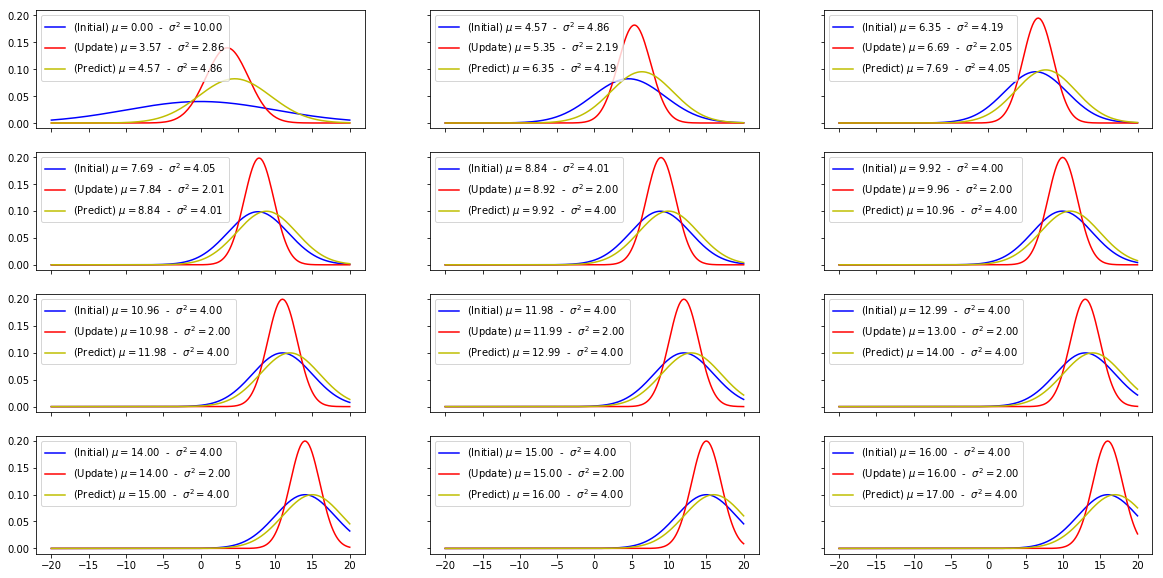

In [16]:
first = 5
last = 16
measurements = list(np.linspace(first,last,last-first+1))
motion = list(np.ones(len(measurements)))

# Variance of measurement
measurement_sig = 4.
# Variance of action
motion_sig = 2.
# Initial mu
mu = 0.
# Initial variance
sig = 10.
points = 200
plot_kalman_process(mu, sig, points, measurements, motion)

Interesante que cuando la medicion inicial es con varianza tendiendo a infinito 1000, es la convolucion con la medicion por lo que es como arrancar con la medicion.
Si la varianza es chica y la media no cumple con el modelo, el sistema tarda mas en converger

Linear Gaussian Markin Model = Kalman filter

In [17]:
# measurement
sig_v = measurement_sig
# Variance of action
sig_w = motion_sig
a = 1
P_pred = (sig_w + sig_v*(a**2-1) +  np.sqrt((sig_w + sig_v*(a**2-1))**2 + 4*sig_w*sig_v))/2
P_obs = P_pred - sig_w
K = P_pred/(P_pred + sig_v)
p_n1 = (1-K)*P_pred + sig_w
print(P_pred, P_obs, K, p_n1)

4.0 2.0 0.5 4.0
